In [1]:
%load_ext autoreload

In [14]:
%autoreload 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

import utilities as ut
from sklearn.model_selection import train_test_split

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [3]:
from featurewiz import FeatureWiz

Imported 0.3.2 version. Select nrows to a small number when running on huge datasets.
output = featurewiz(dataname, target, corr_limit=0.90, verbose=2, sep=',', 
		header=0, test_data='',feature_engg='', category_encoders='',
		dask_xgboost_flag=False, nrows=None, skip_sulov=False, skip_xgboost=False)
Create new features via 'feature_engg' flag : ['interactions','groupby','target']



# Create train data


In [5]:
# Read and structure all the parquet files in the data folder
data_list = ut.read_data()

In [6]:
# Create a data processor object
Data = ut.DataProcessor(data_list)

In [7]:
# Create the formatted dataframe
df = Data.create_train_data()

<Axes: xlabel='date_forecast'>

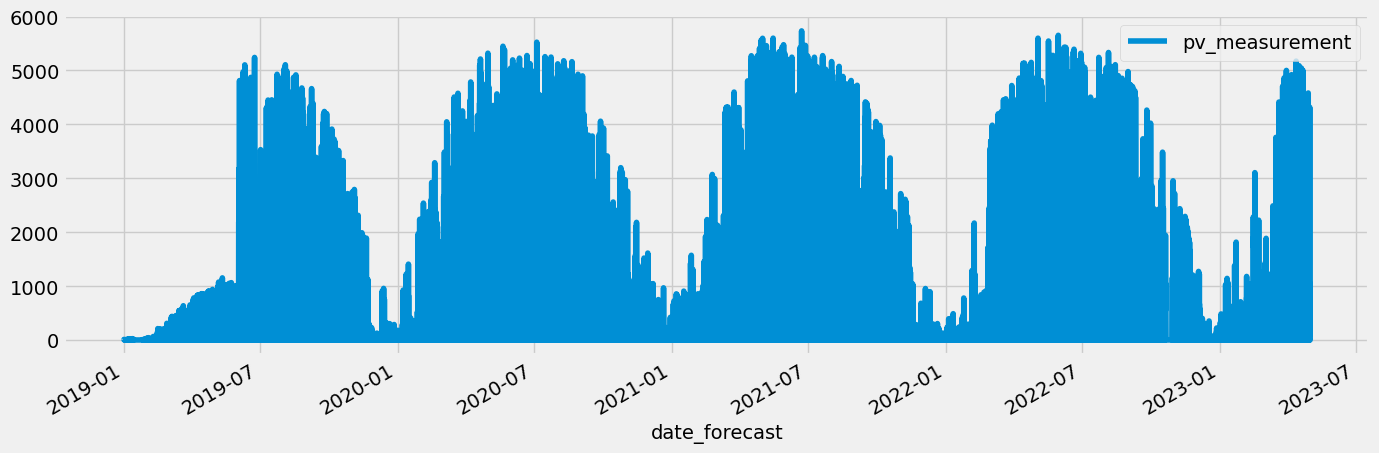

In [8]:
# plot db features column pv_measurement against the index iof the dataframe
df.plot(y='pv_measurement', figsize=(15, 5))

Seems like we are missing a lot of data in the first half of 2019

In [9]:
# slice df to only include from 2019-09-04 08:00:00 onwards (this is where we have data for all features)
df.sort_index(inplace=True)
df = df.loc['2019-09-04 08:00:00':]

<Axes: xlabel='date_forecast'>

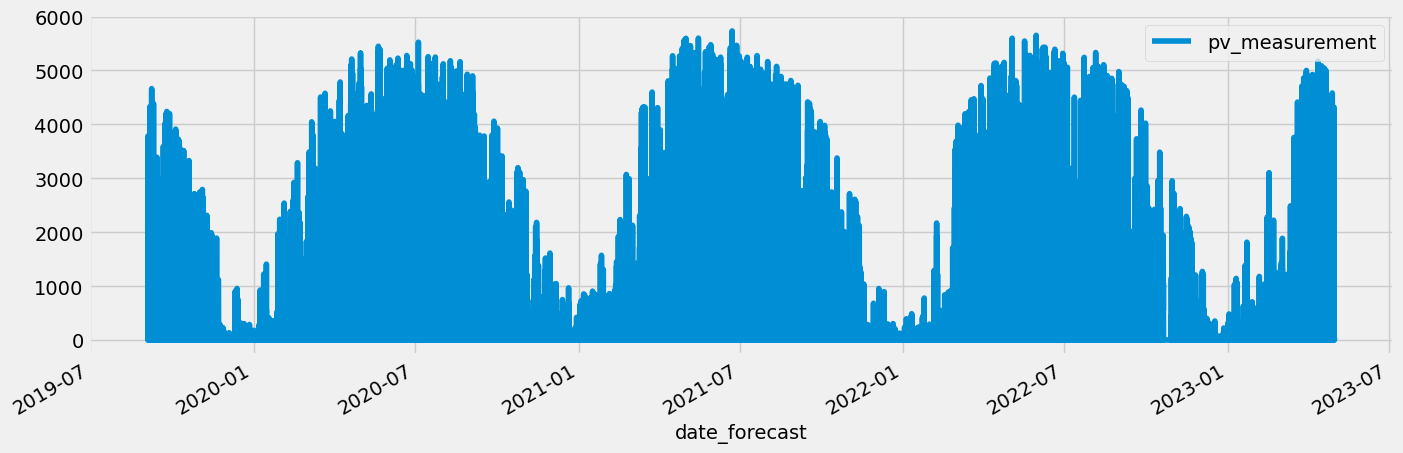

In [10]:
# createa add_lags function 
df.plot(y='pv_measurement', figsize=(15, 5))

## Feature Engineering

In [11]:
FEATURES = list(df.columns)
FEATURES.remove('pv_measurement')
FEATURES.remove('building') # this is a categorical feature that we will not use

TARGET = 'pv_measurement'

X_train = df[FEATURES]
y_train = df[TARGET]

X_test = Data.create_test_data()
X_test = X_test[FEATURES]

wiz = FeatureWiz(verbose=1)
        X_train_selected = wiz.fit_transform(X_train, y_train)
        X_test_selected = wiz.transform(X_test)
        wiz.features  ### provides a list of selected features ###            
        
############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
featurewiz has selected 0.7 as the correlation limit. Change this limit to fit your needs...
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
#### Single_Label Regression problem ####
    Loaded train data. Shape = (84798, 53)
    Some column names had special characters which were removed...
#### Single_Label Re

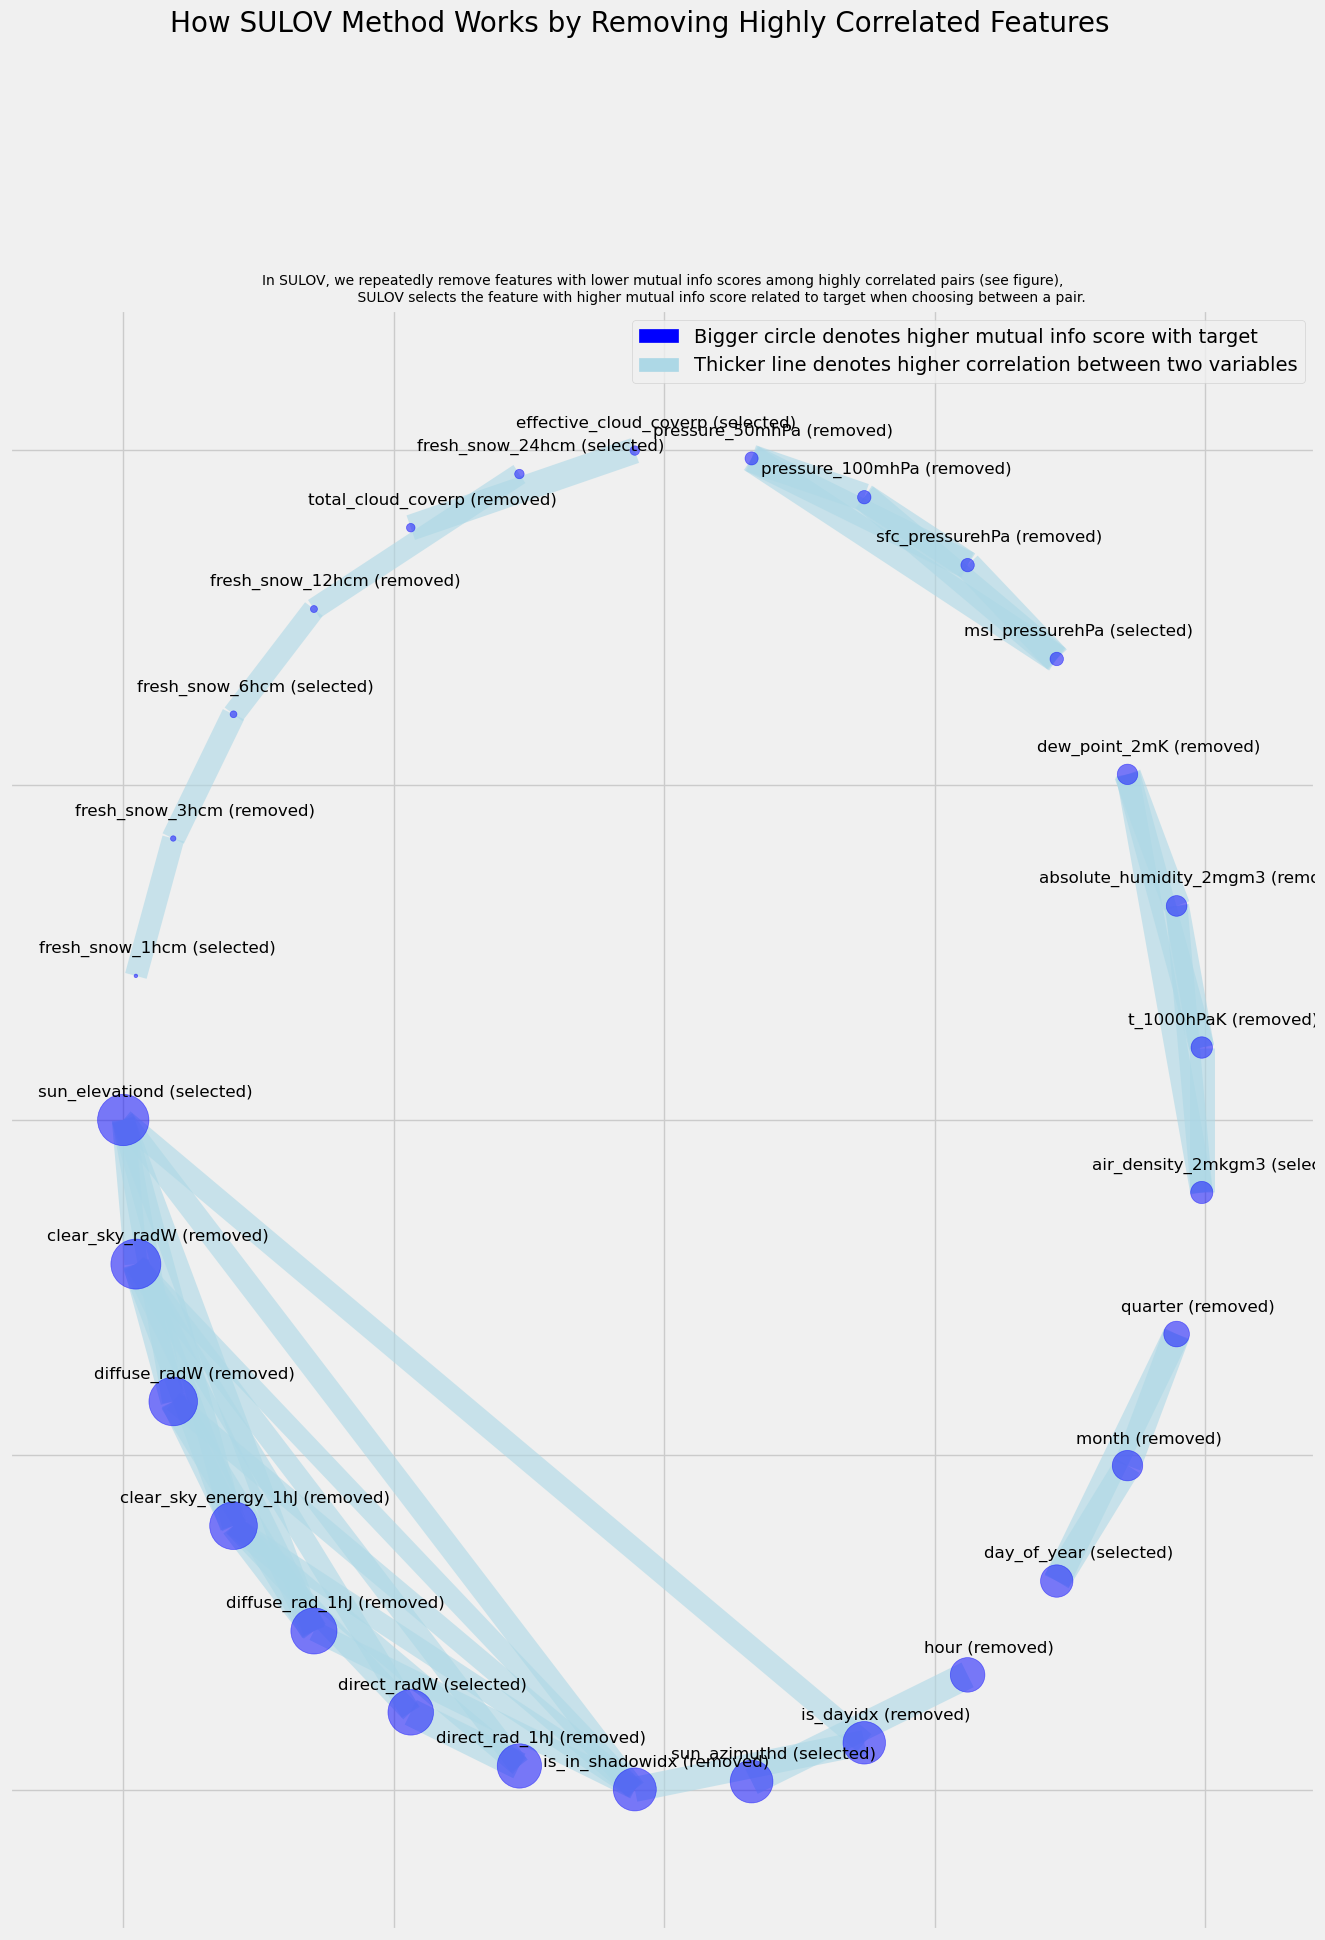

Time taken for SULOV method = 12 seconds
    Adding 0 categorical variables to reduced numeric variables  of 31
Finally 31 vars selected after SULOV
Converting all features to numeric before sending to XGBoost...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
    Taking top 12 features per iteration...
    XGBoost version using 1.7.3 as tree method: hist
    Number of booster rounds = 100
        Selected: ['direct_radW', 'elevationm', 'sun_elevationd', 'sun_azimuthd', 'day_of_year', 'air_density_2mkgm3', 'wind_speed_u_10mms', 'msl_pressurehPa', 'cloud_base_aglm', 'ceiling_height_aglm', 'visibilitym', 'wind_speed_10mms']
            Time taken for regular XGBoost feature selection = 4 seconds
        Selected: ['direct_radW', 'sun_elevationd', 'vi

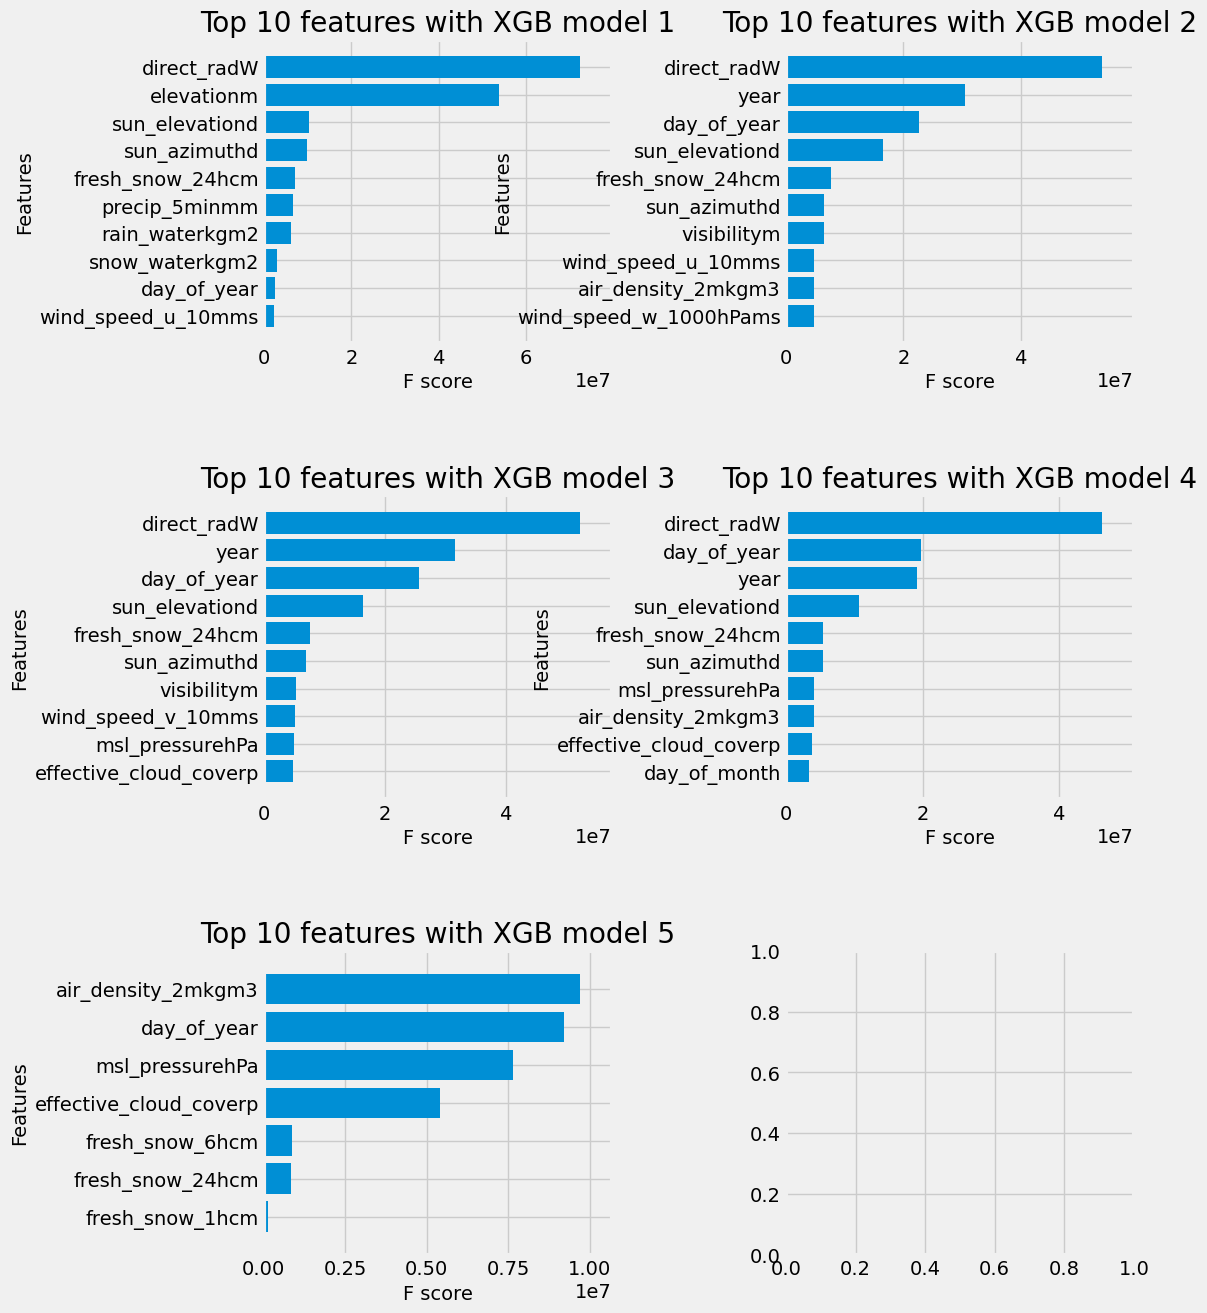

    Completed XGBoost feature selection in 0 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 21 important features:
['direct_radW', 'elevationm', 'sun_elevationd', 'sun_azimuthd', 'day_of_year', 'air_density_2mkgm3', 'wind_speed_u_10mms', 'msl_pressurehPa', 'cloud_base_aglm', 'ceiling_height_aglm', 'visibilitym', 'wind_speed_10mms', 'year', 'relative_humidity_1000hPap', 'wind_speed_v_10mms', 'effective_cloud_coverp', 'day_of_month', 'fresh_snow_24hcm', 'day_of_week', 'fresh_snow_6hcm', 'fresh_snow_1hcm']
Total Time taken for featurewiz selection = 25 seconds
Output contains a list of 21 important features and a train dataframe
    Time taken to create entire pipeline = 25 second(s)


In [12]:
fwiz = FeatureWiz(corr_limit=0.70, feature_engg='', category_encoders='', dask_xgboost_flag=False, nrows=None, verbose=2)
X_train_selected = fwiz.fit_transform(X_train, y_train)
X_test_selected = fwiz.transform(X_test)
### get list of selected features ###
feats = fwiz.features  

In [13]:
X_test_selected.to_csv('X_test_selected.csv')
X_train_selected.to_csv('X_train_selected.csv')
y_train.to_csv('y_train.csv')

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train_selected, y_train, train_size=0.90, random_state=42)

In [ ]:
valdiation_frame = pd.concat([X_test, Y_test], axis=1)
valdiation_frame.to_csv('validation_frame.csv')
training_frame = pd.concat([X_train, Y_train], axis=1)
training_frame.to_csv('training_frame.csv')